# NNMF with ICNN for multi-label classification

## Imports

In [1]:
import csv
import os
import time
import pickle as pkl
import numpy as np
from statistics import mean 
from sklearn.metrics import f1_score
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import mca
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

## Working with dataset

In [2]:
def _loadTxt(fName):
    return np.loadtxt(fName, delimiter=',', skiprows=1, dtype=np.float32)

def cache(dirPath):
    cacheF = os.path.join(dirPath, 'cache.pkl')
    if os.path.isfile(cacheF):
        with open(cacheF, 'rb') as f:
            return pkl.load(f)
    return None

def loadBibtex(dirPath):
    cacheF = os.path.join(dirPath, 'cache.pkl')
    d = cache(dirPath)
    if d is None:
        train = _loadTxt(os.path.join(dirPath, "bibtex-train.csv"))
        trainX, trainY = np.split(train, [1836], axis=1)
        test = _loadTxt(os.path.join(dirPath, "bibtex-test.csv"))
        testX, testY = np.split(test, [1836], axis=1)
        d = {'trainX': trainX, 'trainY': trainY,
            'testX': testX, 'testY': testY}
        with open(cacheF, 'wb') as f:
            pkl.dump(d, f)

    return d

In [3]:
data = loadBibtex("data/bibtex")

trainX = data['trainX']
trainY = data['trainY']
testX = data['testX']
testY = data['testY']

In [4]:
tr_tstX = np.vstack((trainX,testX))
tr_tstY = np.vstack((trainY,testY))
tr_tstX_data = pd.DataFrame(tr_tstX)

In [5]:
mca_ben = mca.MCA(tr_tstX_data, ncols=420)
print(mca.MCA.__doc__)

Run MCA on selected columns of a pd DataFrame.
	
	If the column are specified, assume that they hold
	categorical variables that need to be replaced with
	dummy indicators, otherwise process the DataFrame as is.

	'cols': The columns of the DataFrame to process.
	'ncols': The number of columns before dummy coding. To be passed if cols isn't.
	'benzecri': Perform Benzécri correction (default: True)
	'TOL': value below which to round eigenvalues to zero (default: 1e-4)
	


In [6]:
new_x = mca_ben.fs_r(1)
trainX, testX = np.split(new_x, [4880], axis=0)
trainY, testY = np.split(tr_tstY, [4880], axis=0)

In [7]:
input_dim = trainX.shape[1]
output_dim = trainY.shape[1]
batch_size_train = trainX.shape[0]//15
batch_size_test = testX.shape[0]//10 

hidden_layer_sizes=[135, 110]

In [8]:
class BibtexData(torch_data.Dataset):
    def __init__(self, X, y):
        super(BibtexData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx]

In [9]:
train_dset = BibtexData(trainX, trainY) 
test_dset = BibtexData(testX, testY) 

## ICNN

In [10]:
class ConvexLayer(nn.Module):
    __constants__ = ['input_features', 'output_features', 'weight', 'bias']

    def __init__(self, input_features, output_features, W, H, bias=False, nmf=False):
        super(ConvexLayer, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.W = torch.Tensor(W)
        self.H = torch.Tensor(H)
        self.nmf = nmf
        
        self.weight = nn.Parameter(torch.Tensor(
            torch.randn(output_features, input_features)
        ))
        if bias == True:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        if self.nmf == True:
            output = F.linear(input, self.H)
            linear = F.linear(output, self.W, self.bias)
        else:
            linear = F.linear(input, self.weight, self.bias)
        return linear

In [11]:
class DenseICNN(nn.Module):
    def __init__(self, input_dim, output_dim,  hidden_layer_sizes, W, H, activation='celu', dropout=0.3, nmf=False):
        super(DenseICNN, self).__init__()
        
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.droput = dropout
        self.activation = activation

        
        self.quadratic_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, output_features, bias=True),
                nn.Dropout(dropout))
            for output_features in hidden_layer_sizes])
        
        sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.convex_layers = nn.ModuleList([
            nn.Sequential(
                ConvexLayer(input_features, output_features, W=W, H=H, bias=True, nmf=nmf),
                nn.Dropout(dropout))
            for (input_features, output_features) in sizes])
        
        self.final_layer = nn.Linear(hidden_layer_sizes[-1], output_dim, bias=True)
        
                        
    def forward(self, input):
        output = self.quadratic_layers[0](input)
        for quadratic_layer, convex_layer in zip(self.quadratic_layers[1:], self.convex_layers):
            output = convex_layer(output) + quadratic_layer(input)
            if self.activation == 'celu':
                output = torch.celu(output)
        return self.final_layer(output)
    
    def convexify(self):
        for layer in ICNN.convex_layers:
            for sublayer in layer:
                if (isinstance(sublayer, ConvexLayer)):
                    sublayer.weight.data.clamp_(0)

In [12]:
ICNN = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, W=1, H=1, activation='celu') 

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ICNN.parameters(), lr=0.003, weight_decay=1e-7) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)


train_loader = torch_data.DataLoader(train_dset, batch_size=batch_size_train, shuffle=True) 
test_loader = torch_data.DataLoader(test_dset, batch_size=batch_size_test, shuffle=False) 

## Training procedure

In [13]:
def train(epochs, ICNN, criterion, optimizer, train_loader, test_loader, scheduler=None, verbose=True, save_dir=None):
    
    for epoch in range(1, epochs+1):
        f1 = []
        ICNN.train()
        for X, y in train_loader:
           
            y_out = ICNN(X)

            loss = criterion(y, torch.sigmoid(y_out))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ICNN.convexify()  
            
        ICNN.eval()
        for X, y in test_loader:
            
            y_out = ICNN(X)

            test_loss = criterion(y, torch.sigmoid(y_out))
            predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.5).astype(np.int)
            trueY_bin = y.detach().numpy()
            f1.append(f1_score(trueY_bin.T, predY_bin.T, average='macro', pos_label=None))
            
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,50)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), test_loss.item()))
            print('F1 score:', mean(f1))

In [14]:
train(500, ICNN, criterion, optimizer, train_loader, test_loader, scheduler)

Epoch 50/500 || Loss:  Train 0.0098 | Validation 0.0051
F1 score: 0.22165829663113257
Epoch 100/500 || Loss:  Train 0.0083 | Validation 0.0050
F1 score: 0.26815418400179836
Epoch 150/500 || Loss:  Train 0.0066 | Validation 0.0042
F1 score: 0.3052712975000184
Epoch 200/500 || Loss:  Train 0.0106 | Validation 0.0052
F1 score: 0.32320606931126294
Epoch 250/500 || Loss:  Train 0.0077 | Validation 0.0051
F1 score: 0.3396317914252368
Epoch 300/500 || Loss:  Train 0.0147 | Validation 0.0052
F1 score: 0.3506720283450682
Epoch 350/500 || Loss:  Train 0.0051 | Validation 0.0060
F1 score: 0.35391779059119266
Epoch 400/500 || Loss:  Train 0.0110 | Validation 0.0053
F1 score: 0.3564230884242703
Epoch 450/500 || Loss:  Train 0.0031 | Validation 0.0061
F1 score: 0.3538078616855376
Epoch 500/500 || Loss:  Train 0.0054 | Validation 0.0053
F1 score: 0.3626543644290837


## NNMF with ICNN

In [15]:
def NMF_time(ICNN, sample_loader):
    time_ = []
    for X, y in sample_loader:
        start = time.time()
        pred = ICNN(X)
        end = time.time()
        time_.append(end - start)
    return time_

In [16]:
def NMF_score(ICNN, sample_loader):
    for X, y in sample_loader:
        y_out = ICNN(X)
        predY_bin = (torch.sigmoid(y_out).detach().numpy() >= 0.55).astype(np.int)
        trueY_bin = y.detach().numpy()
    return f1_score(trueY_bin.T, predY_bin.T, average='macro', pos_label=None)

In [17]:
percents = np.linspace(0.10, 1.0, 19)
time1_ = []
time2_ = []
score1_ = []
score2_ = []
for percent in percents:
    ICNN.eval()
    model = NMF(n_components=int(percent*135), init='random', random_state=0)               
    W = model.fit_transform(ICNN.convex_layers[0][0].weight.data.detach().numpy())
    H = model.components_

    sample_loader1 = torch_data.DataLoader(test_dset, batch_size=1, shuffle=False) 
    sample_loader2 = torch_data.DataLoader(test_dset, batch_size=test_dset[:][0].shape[0], shuffle=False)

    ICNN_NMF = DenseICNN(input_dim, output_dim,  hidden_layer_sizes, W=W, H=H, activation='celu', nmf=True) 
    ICNN_NMF.eval()

    ICNN_NMF.quadratic_layers[0][0].weight.data = ICNN.quadratic_layers[0][0].weight.data
    ICNN_NMF.quadratic_layers[1][0].weight.data = ICNN.quadratic_layers[1][0].weight.data
    ICNN_NMF.quadratic_layers[0][0].bias.data = ICNN.quadratic_layers[0][0].bias.data
    ICNN_NMF.quadratic_layers[1][0].bias.data = ICNN.quadratic_layers[1][0].bias.data
    ICNN_NMF.convex_layers[0][0].bias.data = ICNN.convex_layers[0][0].bias.data
    ICNN_NMF.final_layer.weight.data = ICNN.final_layer.weight.data
    ICNN_NMF.final_layer.bias.data = ICNN.final_layer.bias.data

    time1 = NMF_time(ICNN, sample_loader1)
    time2 = NMF_time(ICNN_NMF, sample_loader1)

    score1 = NMF_score(ICNN, sample_loader2)
    score2 = NMF_score(ICNN_NMF, sample_loader2)

    time1_.append(np.sum(time1))
    time2_.append(np.sum(time2))

    score1_.append(score1)
    score2_.append(score2)

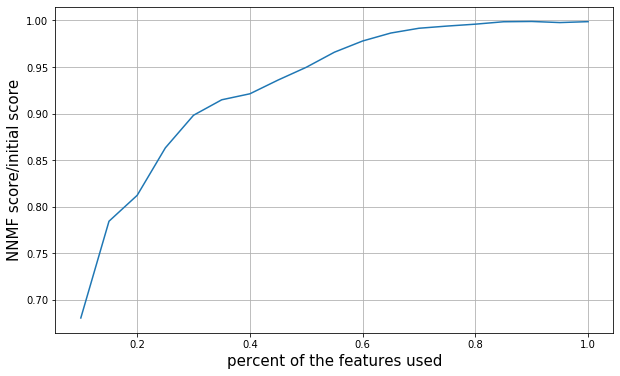

In [18]:
f = plt.figure(figsize=(10,6))
plt.plot(percents,score2_/score1)
plt.xlabel('percent of the features used', fontsize=15)
plt.ylabel('NNMF score/initial score', fontsize=15)
plt.grid()
f.savefig("score_NNMF.jpg", bbox_inches='tight')

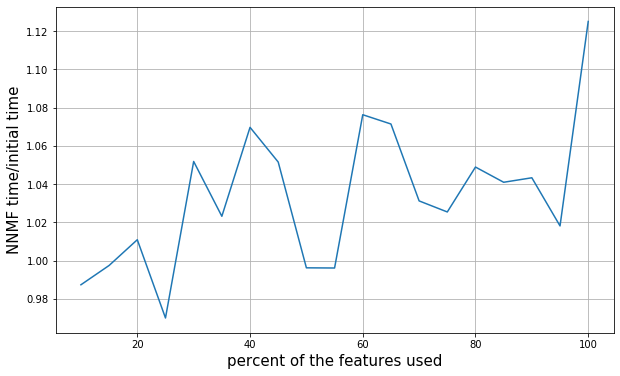

In [19]:
f = plt.figure(figsize=(10,6))
plt.plot(percents*100.0,np.array(time2_)/np.array(time1_))
plt.xlabel('percent of the features used', fontsize=15)
plt.ylabel('NNMF time/initial time', fontsize=15)
plt.grid()
f.savefig("time_NNMF.jpg", bbox_inches='tight')